In [2]:
pip install scikit-learn

  Using cached scikit_learn-1.7.2-cp310-cp310-win_amd64.whl (8.9 MB)
  Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
  Using cached scipy-1.15.3-cp310-cp310-win_amd64.whl (41.3 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ Data loaded successfully: (4550, 13)
🔍 CTR anomalies detected: 0
🔍 CVR anomalies detected: 0
🔍 Cost anomalies detected: 65
🤖 Isolation Forest detected 137 anomalies


C:\Users\MullapudiMaheshSai\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


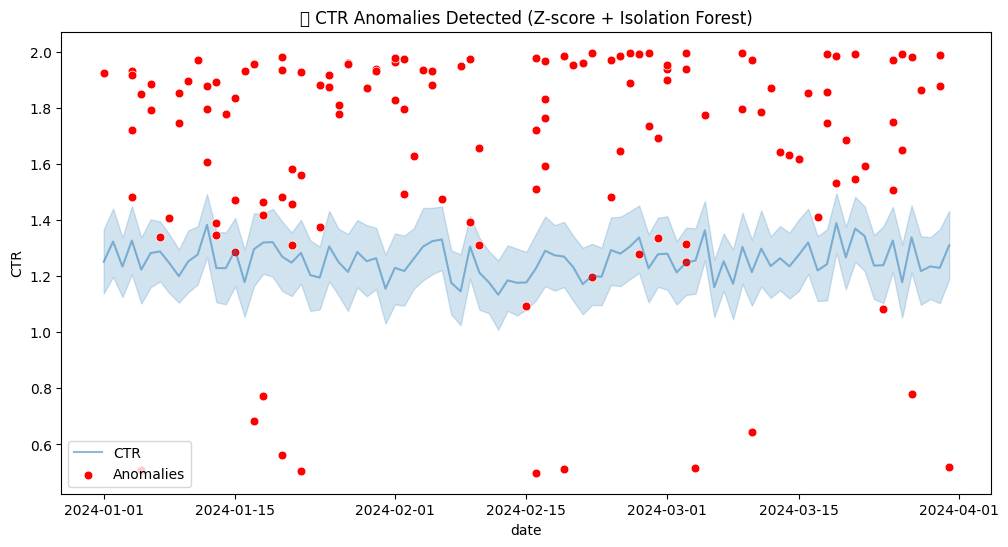

C:\Users\MullapudiMaheshSai\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


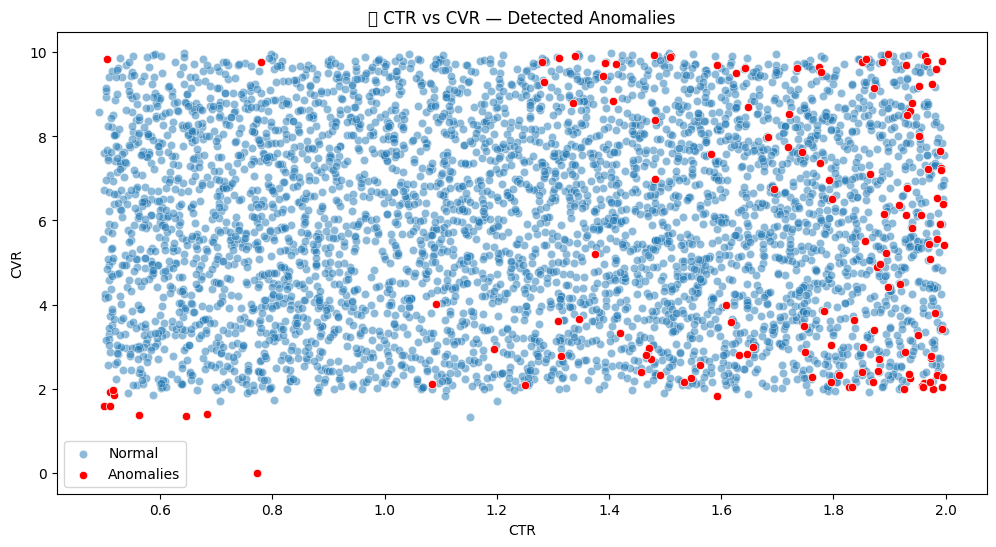

In [3]:
# ======================================================
# 🚨 Step 3: Campaign Performance Anomaly Detection
# ======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from scipy import stats

# Load cleaned dataset
df = pd.read_csv("../data/adtech_campaign_cleaned.csv", parse_dates=["date"])
print("✅ Data loaded successfully:", df.shape)

# ========================================
# 🧮 Step 1: Aggregate Metrics per Day per Campaign
# ========================================

daily_metrics = (
    df.groupby(["campaign_id", "date"])
      [["CTR", "CVR", "cost"]]
      .mean()
      .reset_index()
)

# ========================================
# ⚙️ Step 2: Detect Anomalies using Z-Score Method
# ========================================

def detect_anomalies_zscore(data, column, threshold=3):
    z_scores = np.abs(stats.zscore(data[column]))
    return data[z_scores > threshold]

ctr_anomalies = detect_anomalies_zscore(daily_metrics, "CTR")
cvr_anomalies = detect_anomalies_zscore(daily_metrics, "CVR")
cost_anomalies = detect_anomalies_zscore(daily_metrics, "cost")

print(f"🔍 CTR anomalies detected: {len(ctr_anomalies)}")
print(f"🔍 CVR anomalies detected: {len(cvr_anomalies)}")
print(f"🔍 Cost anomalies detected: {len(cost_anomalies)}")

# ========================================
# 🤖 Step 3: Isolation Forest for Multivariate Anomaly Detection
# ========================================

iso_data = daily_metrics[["CTR", "CVR", "cost"]].copy()
model = IsolationForest(contamination=0.03, random_state=42)
daily_metrics["anomaly_flag"] = model.fit_predict(iso_data)

# -1 indicates anomaly
anomalies_if = daily_metrics[daily_metrics["anomaly_flag"] == -1]
print(f"🤖 Isolation Forest detected {len(anomalies_if)} anomalies")

# ========================================
# 📊 Step 4: Visualization of Anomalies
# ========================================

plt.figure(figsize=(12, 6))
sns.lineplot(x="date", y="CTR", data=daily_metrics, label="CTR", alpha=0.5)
sns.scatterplot(
    x="date", y="CTR",
    data=anomalies_if, color="red", label="Anomalies", s=40
)
plt.title("🚨 CTR Anomalies Detected (Z-score + Isolation Forest)")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(
    x="CTR", y="CVR",
    data=daily_metrics, alpha=0.5, label="Normal"
)
sns.scatterplot(
    x="CTR", y="CVR",
    data=anomalies_if, color="red", label="Anomalies"
)
plt.title("📉 CTR vs CVR — Detected Anomalies")
plt.legend()
plt.show()

# ========================
